In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [ ]:
titanic_data = pd.read_csv("/content/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


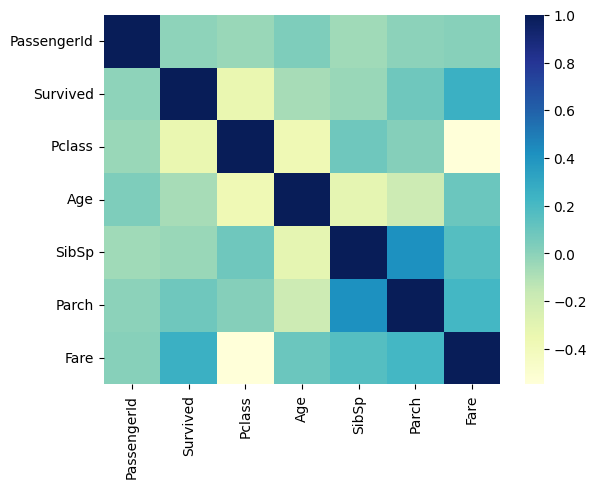

In [ ]:
# Select only numerical columns for correlation calculation
numerical_titanic_data = titanic_data.select_dtypes(include=np.number)
# Calculate and plot the heatmap using only numerical data
sns.heatmap(numerical_titanic_data.corr(), cmap ="YlGnBu")
plt.show()

In [ ]:
# Create the StratifiedShuffleSplit object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Perform the split, using a list of column names for stratification
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', "Pclass", "Sex"]]):
    # Select the training and testing sets using the generated indices
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

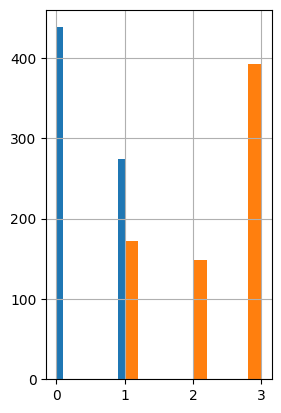

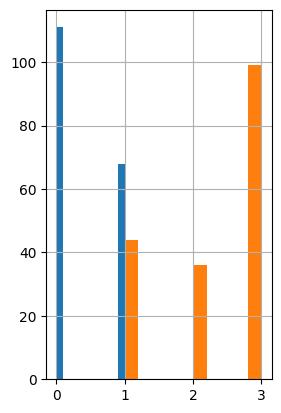

In [ ]:
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()
plt.show()
plt.subplot(1,2,1)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()
plt.show()

In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [ ]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [ ]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder =  OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()

        column_names = ["C", "S", "Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        column_names = ["female", "male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [ ]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Name","Ticket","Cabin","Embarked","Sex", "N"],axis=1, errors="ignore")

In [ ]:
pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureenconder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [ ]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [ ]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
867,868,0,1,31.0,0,0,50.4958,0.0,0.0,1.0,0.0,1.0
619,620,0,2,26.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
50,51,0,3,7.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
286,287,1,3,30.0,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
834,835,0,3,18.0,0,0,8.3000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
518,519,1,2,36.0,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
54,55,0,1,65.0,0,1,61.9792,1.0,0.0,0.0,0.0,1.0
603,604,0,3,44.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  female       712 non-null    float64
 11  male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [ ]:
scaler = StandardScaler()

X = strat_train_set.drop("Survived", axis=1)
y = strat_train_set["Survived"]
X_data = scaler.fit_transform(X)
y_date = y.to_numpy()

In [ ]:
clf = RandomForestClassifier()

param_grid = [
    {"n_estimators":[10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_date)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(min_samples_split=4)

In [ ]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [ ]:
X_test = strat_test_set.drop("Survived", axis=1)
y_test = strat_test_set["Survived"]
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
y_test = y_test.to_numpy()

In [ ]:
final_clf.score(X_test, y_test)

0.8212290502793296

In [ ]:
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [ ]:
X_final = final_data.drop("Survived", axis=1)
y_final = final_data["Survived"]
scaler = StandardScaler()
X_final = scaler.fit_transform(X_final)
y_final = y_final.to_numpy()

In [ ]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators":[10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_final, y_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
prod_final_clf = grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(max_depth=10)

In [ ]:
titanic_test_data = pd.read_csv("/content/test.csv")
titanic_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,female,male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [ ]:
X_final_test =  final_test_data
X_final_test = X_final_test.fillna(method="ffill")
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

<ipython-input-204-ff16aabcb85d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [ ]:
predictions = prod_final_clf.predict(X_data_final_test)

In [ ]:
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("submission.csv", index=False)

Accuracy after submiting to kaggle


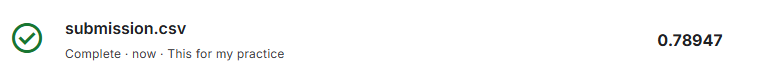